In [22]:
import pickle
import numpy as np
import pandas as pd 
from scipy.stats import norm, gamma, beta 

from scipy.ndimage import gaussian_filter1d
import pingouin as pg 
from tabulate import tabulate


import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys 
sys.path.append("..") 
from utils.bms import fit_bms
from utils.viz import viz
from utils.analyze import build_pivot_table
viz.get_style()

## 1. The phenomenon

Paitents exhibited less flexibility in adapting the environment volatility than the healthy control individuals. 

In [23]:
def HumanAda(mode):

    psi  = np.zeros([180])
    psi[:90]     = .7
    psi[90:110]  = .2
    psi[110:130] = .8
    psi[130:150] = .2
    psi[150:170] = .8
    psi[170:180] = .2

    with open(f'../data/{mode}_exp1data.pkl', 'rb')as handle:
        data = pickle.load(handle)

    cases = {'sta0.7-vol0.2':[], 'sta0.3-vol0.8':[]}

    for subj in data.keys():
        datum = data[subj][0]
        ind = {}
        for btype in ['sta', 'vol']:
            ind[btype] = list(range(90)) if datum.loc[0, 'b_type'] == btype\
                            else list(range(90, 180)) 

        ## stable 
        sel_data = datum.query('b_type=="sta"'
                ).groupby(by='state').count()['trial']
        datum.loc[ind['sta'], 'p0'] = np.round(sel_data[0] / 90, 2)

        ## volatile 
        idx1, idx2 = ind['vol'][0], ind['vol'][0]+19
        n = datum.loc[idx1:idx2].groupby(by='state').count()['trial'][0] / 20
        datum.loc[ind['vol'], 'p0'] = [.2]*20+[.8]*20+[.2]*20+[.8]*20+[.2]*10 if n==.2 else\
                                    [.8]*20+[.2]*20+[.8]*20+[.2]*20+[.8]*10 
        cond = f'{datum.loc[0, "b_type"]}{datum.loc[0, "p0"]}-{datum.loc[90, "b_type"]}{datum.loc[90, "p0"]}'
        if cond in cases.keys():
            cases[cond].append(datum) 
             
    plt.figure(figsize=(10, 4))
            
    cs = ['group=="HC"', 'group!="HC"']
    sel_data = pd.concat(cases['sta0.7-vol0.2']).reset_index()
    sns.lineplot(x=np.arange(180), y=psi, color='k', ls='--')
    lbs = ['HC', 'PAT']
    for i, c in enumerate(cs):
        sel_data = pd.concat(cases['sta0.7-vol0.2']).query(c).reset_index()
        sel_data['humanAct'] = sel_data['humanAct'].apply(
            lambda x: x if mode=='loss' else 1-x)
        sel_data2 = pd.concat(cases['sta0.3-vol0.8']).query(c).reset_index()
        sel_data2['humanAct'] = sel_data2['humanAct'].apply(
            lambda x: 1-x if mode=='loss' else x)
        sdata = pd.concat([sel_data, sel_data2],axis=0, ignore_index=True)
        print(f'{lbs[i]}: {sdata.shape[0]/180}')
        a = sdata.groupby(by='trial')[['humanAct']].mean().reset_index().rolling(5
                        ).mean().values[5-1:]
        b = gaussian_filter1d(a[:,1], sigma=2)
        c = a[:177, 0]
        sdata = pd.DataFrame(np.vstack([c.reshape([-1]), b]).T, columns=['trial', 'humanAct'])
        # sdata = pd.DataFrame(sdata.groupby(by='trial')[['humanAct']].mean().reset_index().rolling(5
        #                 ).mean().values[5-1:], columns=['trial', 'humanAct'])
        sns.lineplot(x='trial', y='humanAct', data=sdata, color=viz.PurplePairs[i], ci=0, label=lbs[i])
    plt.legend()
    plt.ylim([-.1, 1.1])
    plt.xlabel('Trials')
    plt.ylabel('Prob. of choosing \nthe left stimulus')
    plt.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


HC: 26.0
PAT: 17.0


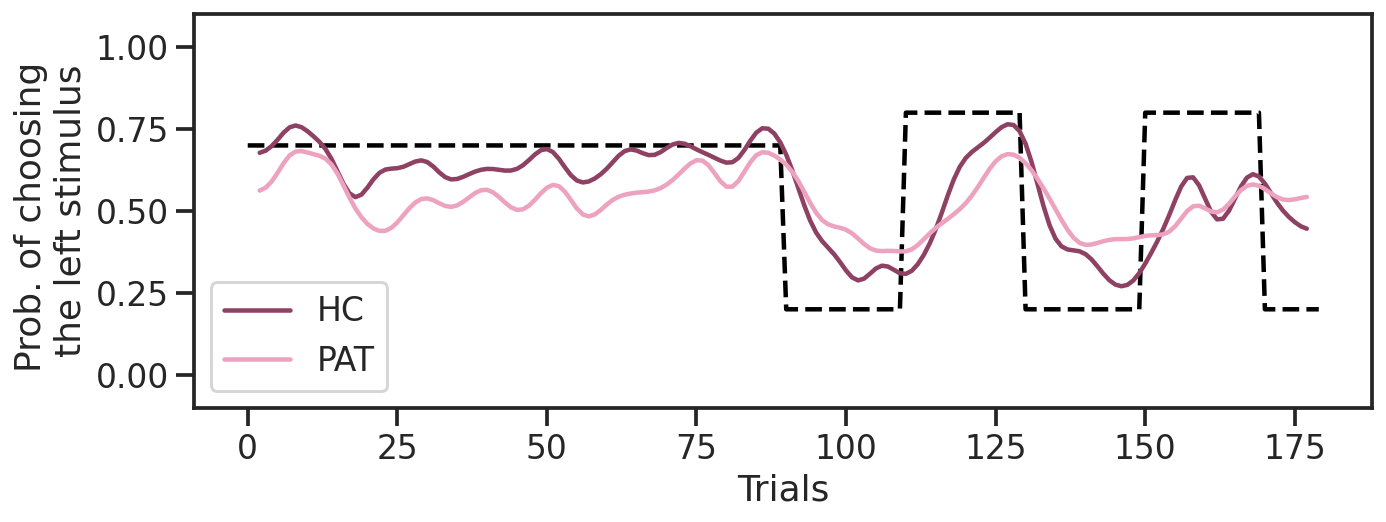

In [24]:
## Human data 
HumanAda(mode='loss')
plt.show()

## 2. Two possible explanations:

### 2.1 Explanation 1: different learning rate, same decision style 

Patients and healthy control had the same decision style but different learning rates. 

In [25]:
def PolicyAda(mode, model):

    psi  = np.zeros([180])
    psi[:90]     = .7
    psi[90:110]  = .2
    psi[110:130] = .8
    psi[130:150] = .2
    psi[150:170] = .8
    psi[170:180] = .2

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax = ax 
    for i, g in enumerate(['HC', 'PAT']):
        fname = f'../simulations/exp1data/{model}/simsubj-exp1data-sta_first-{g}-{mode}.csv'
        data = pd.read_csv(fname)
        #data = data.groupby(by=['trials'])[['pi']].mean()
        sns.lineplot(x='trials', y='pi', lw=3, ci=95,
                    data=data, color=viz.PurplePairs[i], label=g)
    sns.lineplot(x=np.arange(180), y=psi, color='k', ls='--')
    ax.set_ylabel('Prob. of choosing \nthe left stimulus')
    ax.set_xlabel('Trials')
    ax.legend()
    ax.set_ylim([-.1, 1.1])
    plt.tight_layout()

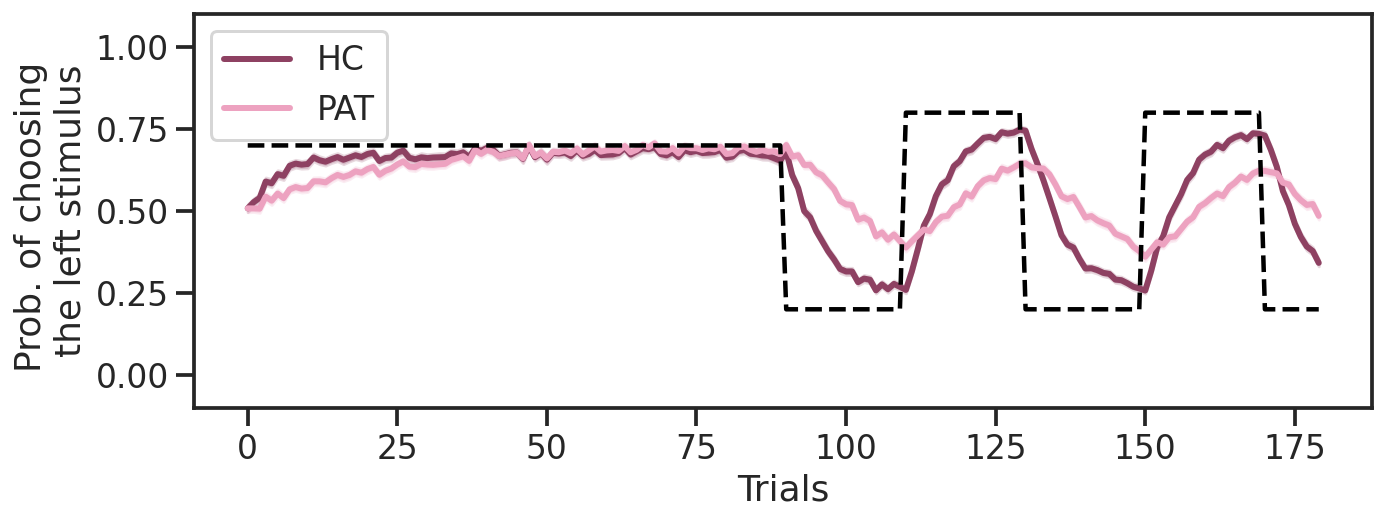

In [26]:
PolicyAda('vary_lr', 'MOS')
plt.show()

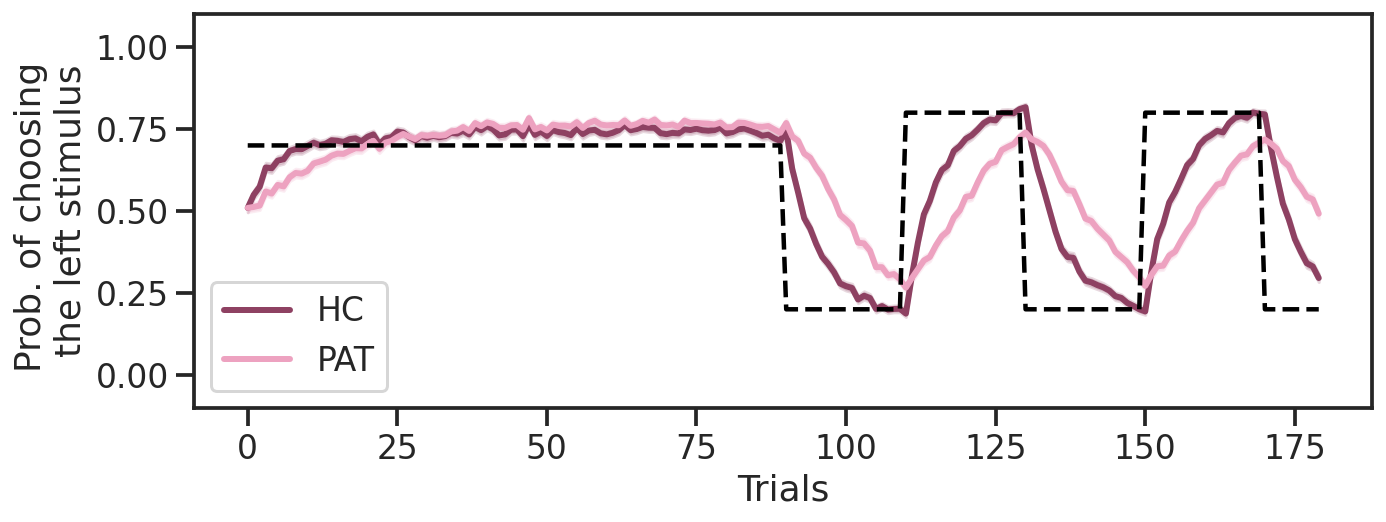

In [27]:
PolicyAda('vary_lr', 'FLR')
plt.show()

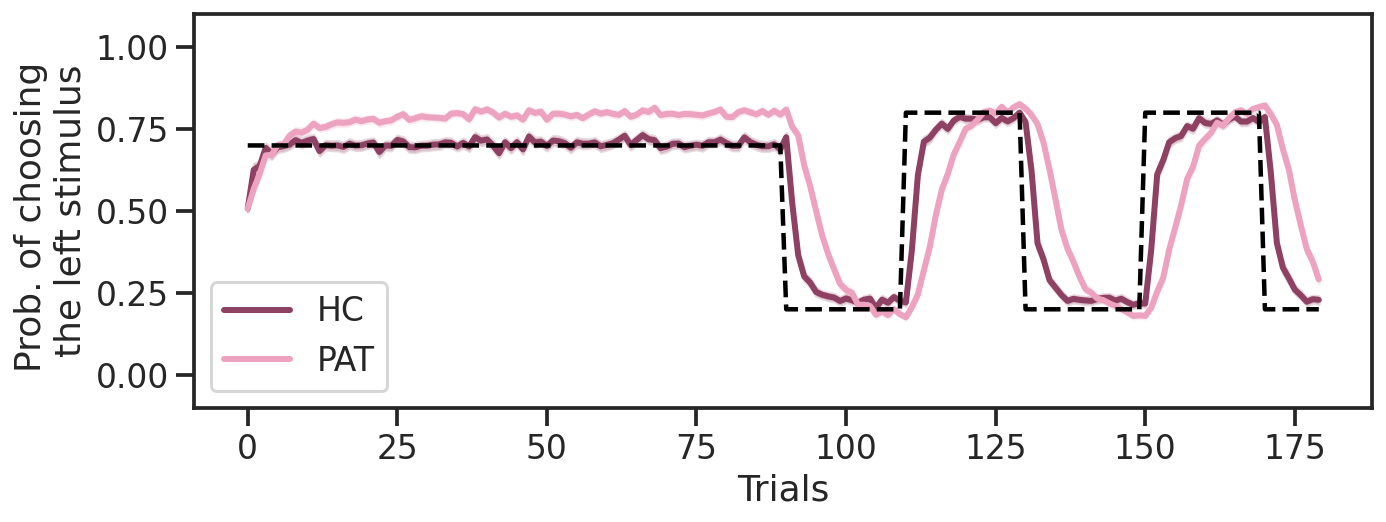

In [28]:
PolicyAda('vary_lr', 'RP')
plt.show()

### 2.2 Explanation 2: the same learning rate, different decision styles

Patients and health control had the same learning rate but different decision styles. 

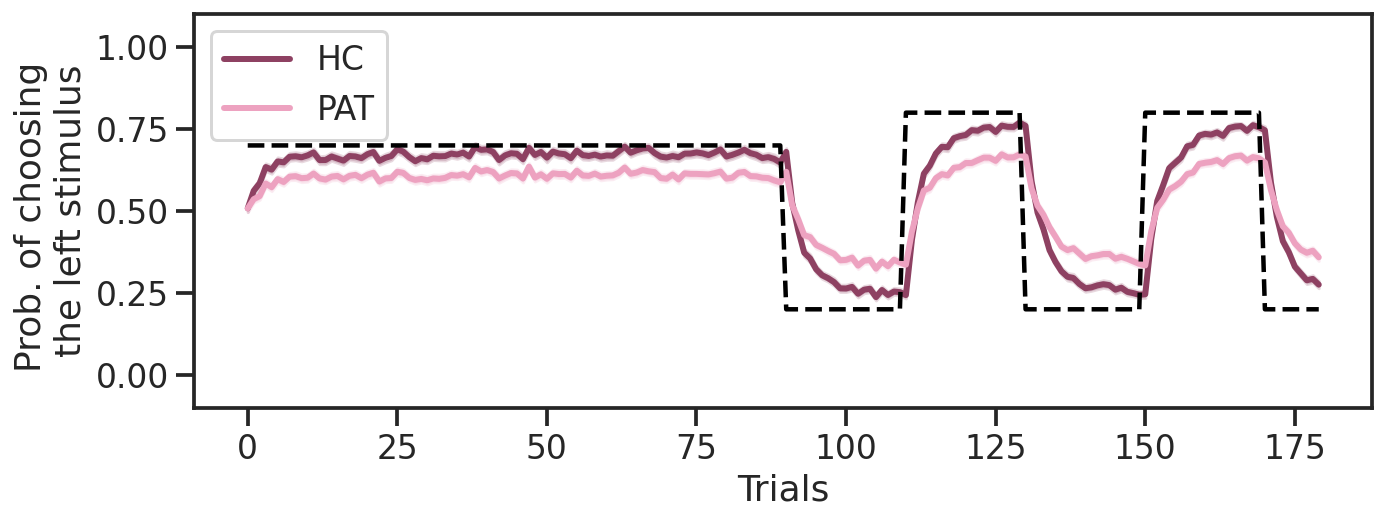

In [29]:
PolicyAda('fix_lr', 'MOS')
plt.show()

## 3. Differentiate the two models

### 3.1 Qualitative difference

If patients and healthy control individuals differ in the learning rate, their asymptotic performance of the stable trials should be similar. 

### 3.2 Quantitative difference

Through parameter recovery

## 4. Parameter recovery

### Generate ground truth parameters

In [30]:
## get the mean paramters 
n_params = 6
fname = '../fits/exp1data/params-exp1data-MOS_fix-bms-ind.csv'
p1_mu  = pd.read_csv(fname, index_col=0).iloc[0, 0:2].values
p1_sig = pd.read_csv(fname, index_col=0).iloc[1, 0:2].values

In [44]:
## get the results
m_types = ['vary_w', 'vary_lr']
groups  = ['HC', 'PAT']

pTable = build_pivot_table('bms', agent='MOS_fix')
pTable['group'] = pTable['group'].map({'HC': 'HC', 'GAD': 'PAT', 'MDD': 'PAT'})

cases = {'vary_w' :{'HC':{}, 'PAT':{}}, 
         'vary_lr':{'HC':{}, 'PAT':{}}}

## get param for vary weights
for g_type in groups:
    lst = pTable.groupby(by=['group']
                    ).mean(numeric_only=True).reset_index(
                    ).query(f'group=="{g_type}"').loc[:, 
                    ['alpha', 'l1', 'l2', 'l3']].values.reshape([-1])
    cases['vary_w'][g_type]['mu'] = np.hstack([p1_mu, lst])
    print(cases['vary_w'][g_type]['mu'].round(3))
    
    lst = [.05, .5, .5, .5]
    cases['vary_w'][g_type]['sig'] = np.hstack([p1_sig, lst])
    print(cases['vary_w'][g_type]['sig'].round(3))

## get param for vary weights
for g_type, lr in zip(groups, [.2, .05]):
    lst = pTable.loc[:, ['l1', 'l2', 'l3']].mean().values.reshape([-1])
    cases['vary_lr'][g_type]['mu'] = np.hstack([p1_mu, lr, lst])
    print(cases['vary_lr'][g_type]['mu'].round(3))
    
    lst = [.05, .5, .5, .5]
    cases['vary_lr'][g_type]['sig'] = np.hstack([p1_sig, lst])
    print(cases['vary_lr'][g_type]['sig'].round(3))


#-------- Clean Outliers ---------- #

    304 rows
    89.4% data has been retained
[ 0.403  8.536  0.463  0.873 -1.575  0.701]
[0.023 0.523 0.05  0.5   0.5   0.5  ]
[ 0.403  8.536  0.47   0.109 -0.072 -0.037]
[0.023 0.523 0.05  0.5   0.5   0.5  ]
[ 0.403  8.536  0.2    0.597 -1.031  0.434]
[0.023 0.523 0.05  0.5   0.5   0.5  ]
[ 0.403  8.536  0.05   0.597 -1.031  0.434]
[0.023 0.523 0.05  0.5   0.5   0.5  ]


In [45]:
n_sub = 20
bnds = [(1e-3, 1-1e-3), (1e-3, 50), (1e-3, 1-1e-3), (-40, 40), (-40, 40), (-40, 40)]

truth_params = {'vary_w':  {'HC': {}, 'PAT': {}}, 
                'vary_lr': {'HC': {}, 'PAT': {}}}
recover_params = {'vary_w':  {'HC': {}, 'PAT': {}}, 
                  'vary_lr': {'HC': {}, 'PAT': {}}}

for m_type in m_types:
    for g_type in groups:
        HC_var  = [norm(loc=cases[m_type][g_type]['mu'][i],  
                      scale=cases[m_type][g_type]['sig'][i]) 
                      for i in range(n_params)]
        samples = np.vstack([[np.clip(rv.rvs().round(4), bnd[0], bnd[1]) 
                        for rv, bnd in zip(HC_var, bnds)] 
                        for _ in range(n_sub)])
        truth_params[m_type][g_type] = samples
        noise = np.vstack([norm(loc=0, scale=.1).rvs([n_sub]), 
                           norm(loc=0, scale= 5).rvs([n_sub]),
                           norm(loc=0, scale=.05).rvs([n_sub])]+
                           [norm(loc=0, scale=.4).rvs([n_sub])]*3).T
        recover_params[m_type][g_type] = samples + noise
        

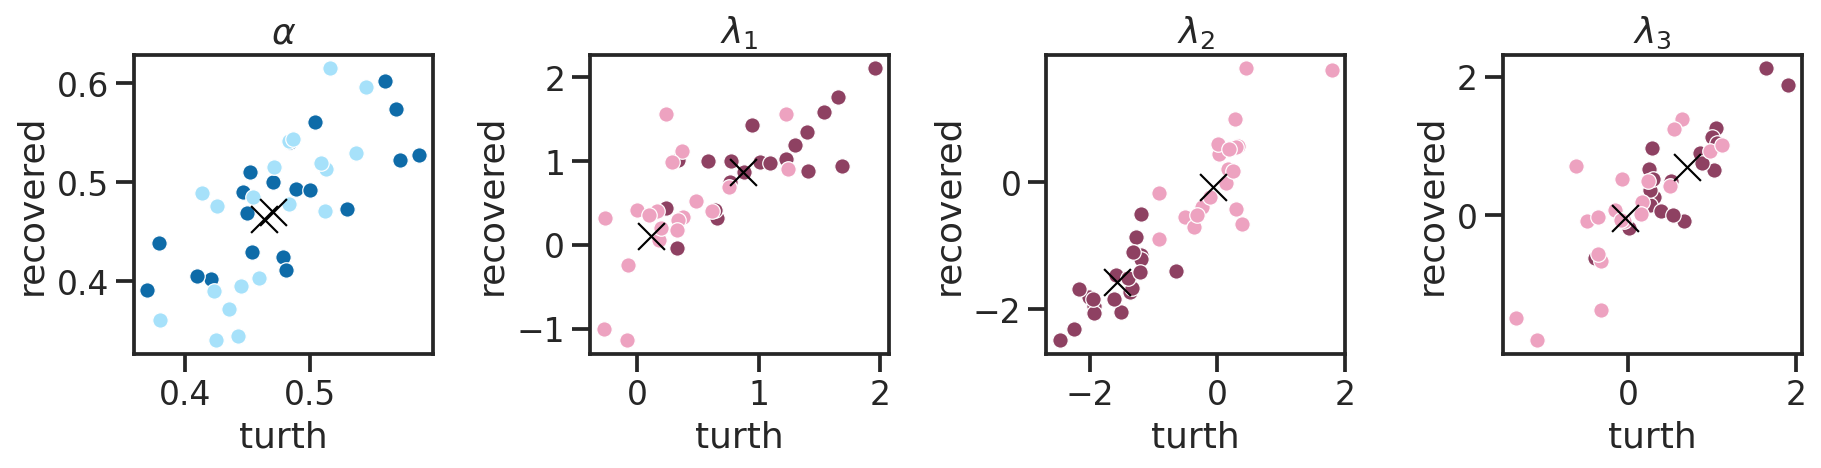

In [46]:
ind = [2, 3, 4, 5]
m_type = 'vary_w'
ticks = [r'$\alpha$', r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$']
colors = [viz.BluePairs] + [viz.PurplePairs]*3
fig, axs = plt.subplots(1, 4, figsize=(13, 4))
for i, p in enumerate(ind):
    ax = axs[i]
    for j, g in enumerate(groups):
        sns.scatterplot(x=truth_params[m_type][g][:, p], 
                        y=recover_params[m_type][g][:, p],
                        color=colors[i][j], s=60, ax=ax)
        sns.scatterplot(x=[cases[m_type][g]['mu'][p]], 
                        y=[cases[m_type][g]['mu'][p]], marker='x',
                        color='k', s=180, zorder=100, ax=ax)
    ax.set_xlabel('turth')
    ax.set_ylabel('recovered')
    ax.set_title(ticks[i])
    ax.set_box_aspect(1)
plt.tight_layout()

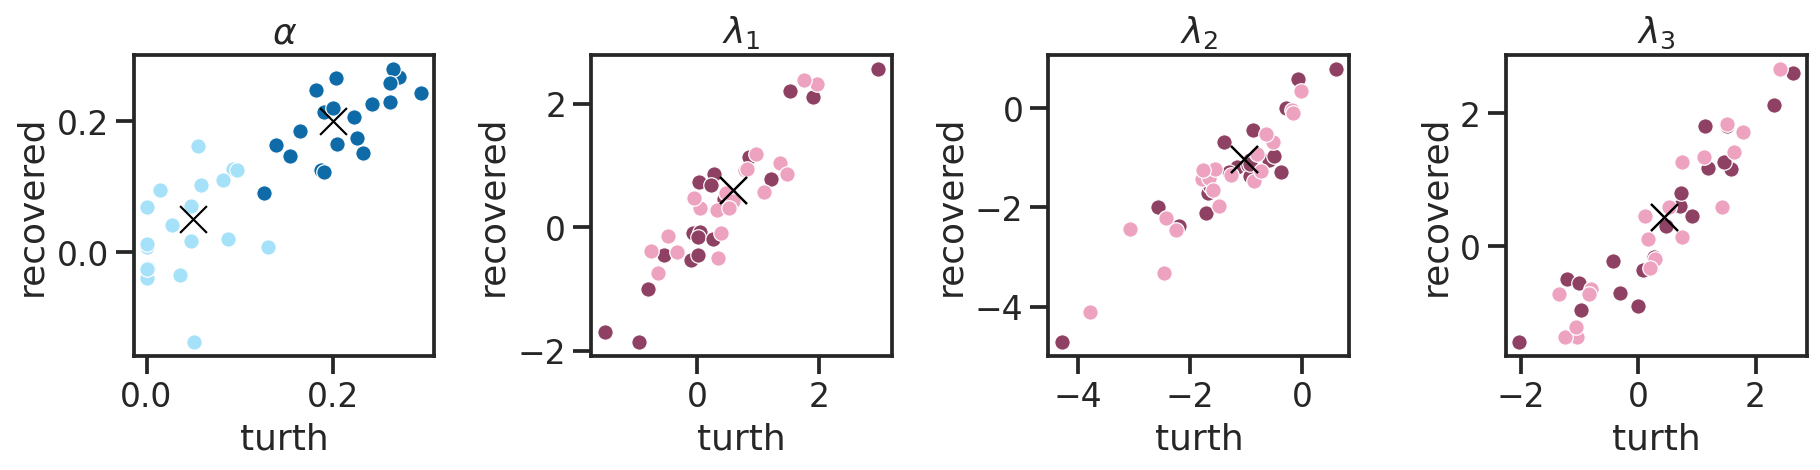

In [39]:
ind = [2, 3, 4, 5]
m_type = 'vary_lr'
ticks = [r'$\alpha$', r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$']
colors = [viz.BluePairs] + [viz.PurplePairs]*3
fig, axs = plt.subplots(1, 4, figsize=(13, 4))
for i, p in enumerate(ind):
    ax = axs[i]
    for j, g in enumerate(groups):
        sns.scatterplot(x=truth_params[m_type][g][:, p], 
                        y=recover_params[m_type][g][:, p],
                        color=colors[i][j], s=60, ax=ax)
        sns.scatterplot(x=[cases[m_type][g]['mu'][p]], 
                        y=[cases[m_type][g]['mu'][p]], marker='x',
                        color='k', s=180, zorder=100, ax=ax)
    ax.set_xlabel('turth')
    ax.set_ylabel('recovered')
    ax.set_title(ticks[i])
    ax.set_box_aspect(1)
plt.tight_layout()

In [40]:
def show_recovery(data, mode):
    
    if mode == 'fix_lr':
        orig_HC  = [0.4637, 0.8954, -1.2135, 0.3179]
        orig_PAT = [0.4637, 0.0393, -0.2128, 0.1736]
    if mode == 'vary_lr':
        orig_HC  = [0.2,    0.5586, -0.7605, 0.2019]
        orig_PAT = [0.05,   0.5586, -0.7605, 0.2019]

    width = .65
    color_lst = [viz.BluePairs, viz.PurplePairs, viz.PurplePairs, viz.PurplePairs]

    # prepare the inputs 
    tars = ['alpha', 'l1', 'l2', 'l3']
    varr = 'group'
    ticks = ['HC', 'PAT']
    data['is_PAT'] = data['group'].apply(lambda x: x!='HC')

    data = data.query(f'sub_id == "{mode}"').groupby(by=['sim_id', 'group']
                    ).mean(numeric_only=True).reset_index()
    data['group'] = data['group'].map({'HC':False, 'PAT':True})
   
    # show bar plot 
    fig, axs = plt.subplots(1, 4, figsize=(12, 4), sharey=True, sharex=True)

    for i, t in enumerate(tars):
        ax = axs[i]
        colors = color_lst[i]

        sns.boxplot(x=varr, y=t, data=data, 
                width=width,
                palette=colors, ax=ax)
        
        x = data.query('group==False')[t].values
        y = data.query('group==True')[t].values
        print(tabulate(pg.ttest(x, y), headers='keys', tablefmt='fancy_grid'))

        p =0 
        for box in ax.patches:
            if box.__class__.__name__ == 'PathPatch':
                box.set_edgecolor(colors[p%2])
                box.set_facecolor('white')
                for k in range(6*p, 6*(p+1)):
                    ax.lines[k].set_color(colors[p%2])
                p += 1
        sns.stripplot(x=varr, y=t, data=data, 
                        jitter=True, dodge=True, marker='o', size=7,
                        palette=colors, alpha=0.5,
                        ax=ax)

        ax.scatter(x=[0, 1], y=[orig_HC[i], orig_PAT[i]], 
                    marker='x', s=100, color='k', zorder=100)
        ax.set_ylim([-5, 5])
        ax.set_xticks([0, 1])
        ax.set_xticklabels(ticks)
        ax.set_xlabel('')
        ax.set_ylabel(f'{t}\n')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

    plt.tight_layout()

In [41]:
fname = f'../simulations/param_recovery-MOS/MOS_fix/sim-param_recovery-MOS-bms-idx0.csv'
data = pd.read_csv(fname)
data = data.dropna(axis='rows')


### Recover MOS_fix (6)

╒════════╤═════════╤═══════╤═══════════════╤══════════╤═══════════════╤═══════════╤════════╤══════════╕
│        │       T │   dof │ alternative   │    p-val │ CI95%         │   cohen-d │   BF10 │    power │
╞════════╪═════════╪═══════╪═══════════════╪══════════╪═══════════════╪═══════════╪════════╪══════════╡
│ T-test │ 1.30905 │    58 │ two-sided     │ 0.195679 │ [-0.02  0.1 ] │  0.337996 │  0.537 │ 0.251203 │
╘════════╧═════════╧═══════╧═══════════════╧══════════╧═══════════════╧═══════════╧════════╧══════════╛
╒════════╤═════════╤═══════╤═══════════════╤═════════════╤═════════════╤═══════════╤═══════════╤═════════╕
│        │       T │   dof │ alternative   │       p-val │ CI95%       │   cohen-d │      BF10 │   power │
╞════════╪═════════╪═══════╪═══════════════╪═════════════╪═════════════╪═══════════╪═══════════╪═════════╡
│ T-test │ 8.31379 │    58 │ two-sided     │ 1.82842e-11 │ [0.74 1.21] │   2.14661 │ 3.383e+08 │       1 │
╘════════╧═════════╧═══════╧═══════════════╧════════

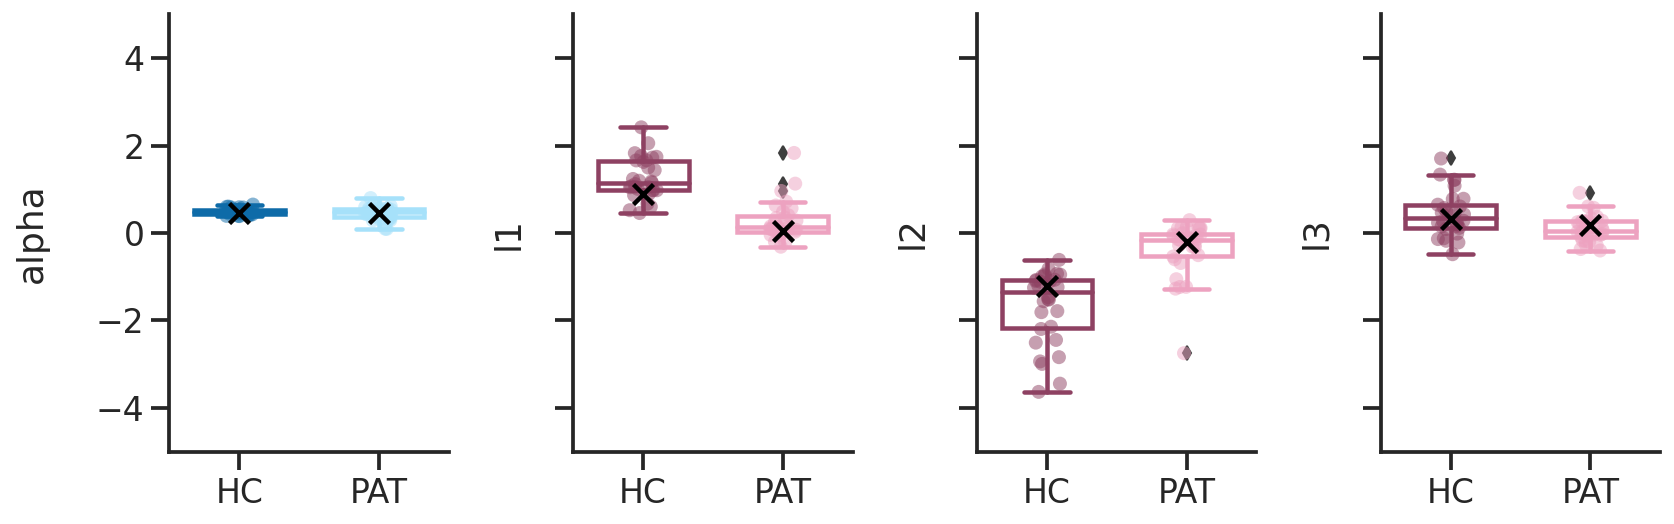

In [42]:
show_recovery(data, 'fix_lr')

╒════════╤═════════╤═══════╤═══════════════╤═════════════╤═════════════╤═══════════╤═════════╤══════════╕
│        │       T │   dof │ alternative   │       p-val │ CI95%       │   cohen-d │    BF10 │    power │
╞════════╪═════════╪═══════╪═══════════════╪═════════════╪═════════════╪═══════════╪═════════╪══════════╡
│ T-test │ 4.25901 │    58 │ two-sided     │ 7.61888e-05 │ [0.07 0.18] │   1.09967 │ 281.107 │ 0.987044 │
╘════════╧═════════╧═══════╧═══════════════╧═════════════╧═════════════╧═══════════╧═════════╧══════════╛
╒════════╤═══════════╤═══════╤═══════════════╤══════════╤═══════════════╤════════════╤════════╤═══════════╕
│        │         T │   dof │ alternative   │    p-val │ CI95%         │    cohen-d │   BF10 │     power │
╞════════╪═══════════╪═══════╪═══════════════╪══════════╪═══════════════╪════════════╪════════╪═══════════╡
│ T-test │ 0.0342289 │    58 │ two-sided     │ 0.972812 │ [-0.4   0.42] │ 0.00883786 │  0.263 │ 0.0501298 │
╘════════╧═══════════╧═══════╧════════

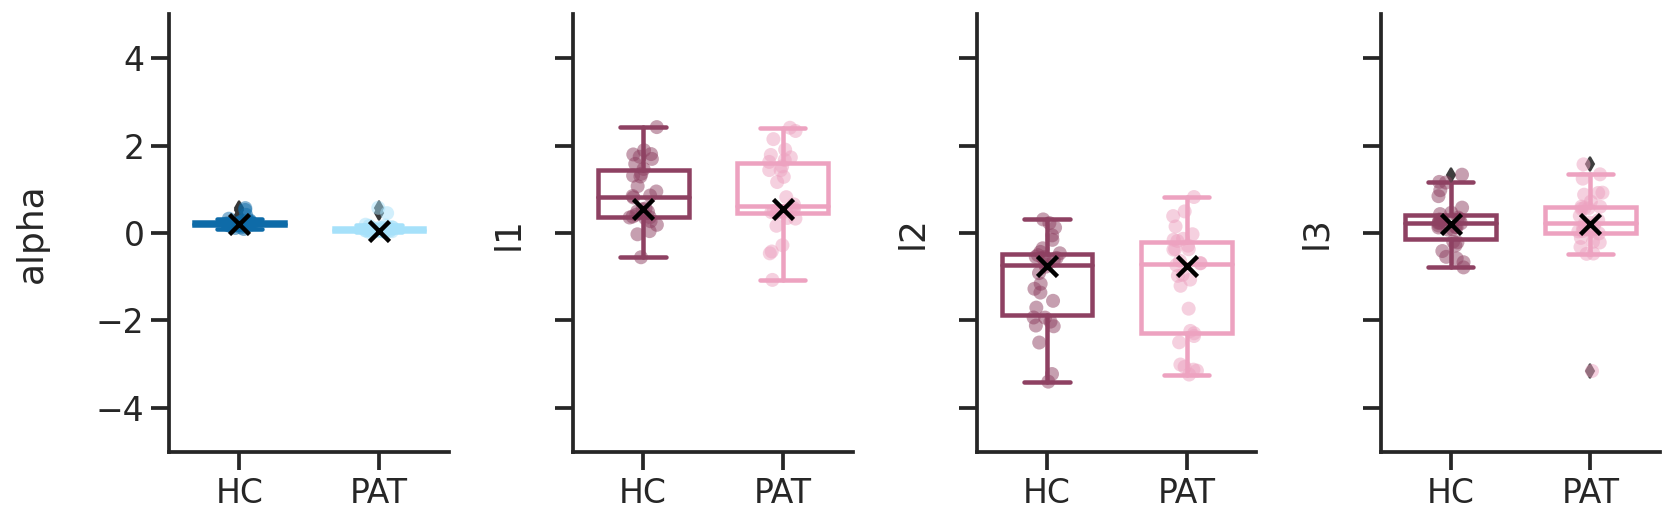

In [43]:
show_recovery(data, 'vary_lr')

### Recover MOS (18)

In [16]:
fname = f'../simulations/param_recovery-MOS/MOS/sim-param_recovery-MOS-bms-idx0.csv'
data = pd.read_csv(fname)
data = data.dropna(axis='rows')

╒════════╤═════════╤═══════╤═══════════════╤═══════════╤═════════════╤═══════════╤════════╤══════════╕
│        │       T │   dof │ alternative   │     p-val │ CI95%       │   cohen-d │   BF10 │    power │
╞════════╪═════════╪═══════╪═══════════════╪═══════════╪═════════════╪═══════════╪════════╪══════════╡
│ T-test │ 1.89453 │    58 │ two-sided     │ 0.0631439 │ [-0.   0.1] │  0.489165 │  1.161 │ 0.461495 │
╘════════╧═════════╧═══════╧═══════════════╧═══════════╧═════════════╧═══════════╧════════╧══════════╛
╒════════╤═════════╤═══════╤═══════════════╤═════════════╤═════════════╤═══════════╤═══════════╤═════════╕
│        │       T │   dof │ alternative   │       p-val │ CI95%       │   cohen-d │      BF10 │   power │
╞════════╪═════════╪═══════╪═══════════════╪═════════════╪═════════════╪═══════════╪═══════════╪═════════╡
│ T-test │ 7.17175 │    58 │ two-sided     │ 1.50829e-09 │ [0.66 1.18] │   1.85174 │ 5.336e+06 │       1 │
╘════════╧═════════╧═══════╧═══════════════╧═════════════

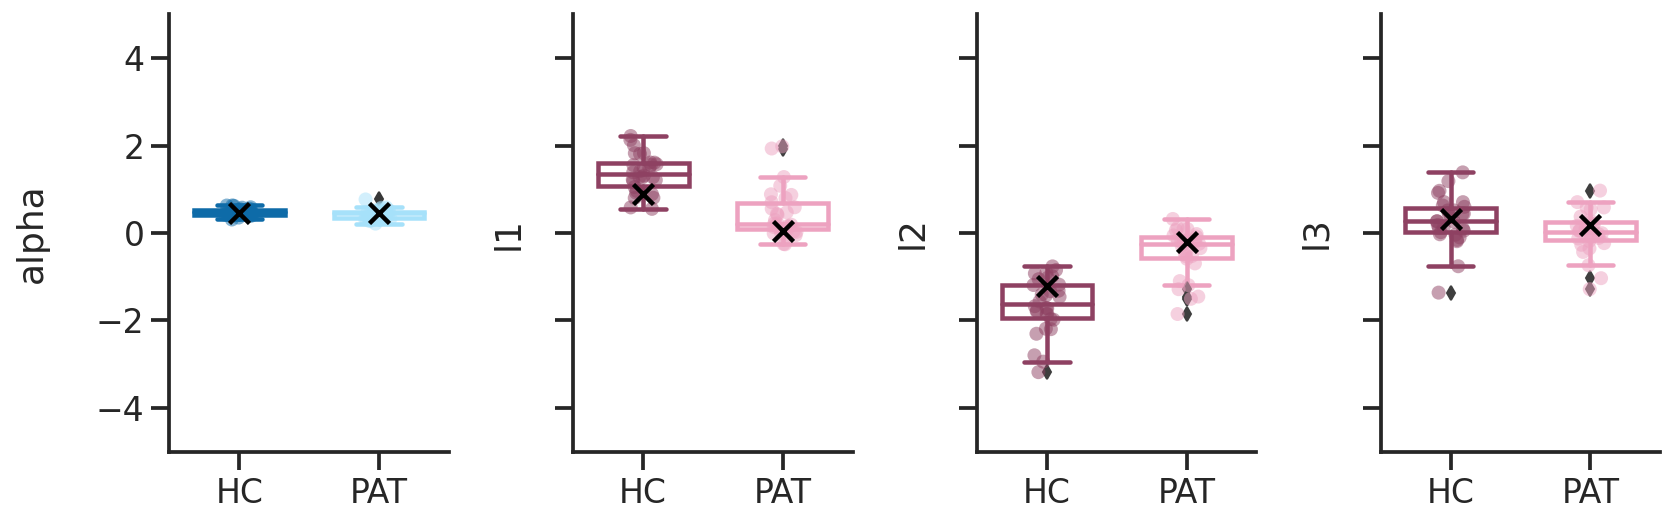

In [17]:
show_recovery(data, 'fix_lr')

╒════════╤══════════╤═══════╤═══════════════╤═════════╤═══════════════╤═══════════╤════════╤═══════════╕
│        │        T │   dof │ alternative   │   p-val │ CI95%         │   cohen-d │   BF10 │     power │
╞════════╪══════════╪═══════╪═══════════════╪═════════╪═══════════════╪═══════════╪════════╪═══════════╡
│ T-test │ 0.214177 │    58 │ two-sided     │ 0.83116 │ [-0.06  0.07] │ 0.0553002 │  0.268 │ 0.0550987 │
╘════════╧══════════╧═══════╧═══════════════╧═════════╧═══════════════╧═══════════╧════════╧═══════════╛
╒════════╤═════════╤═══════╤═══════════════╤════════════╤═════════════╤═══════════╤════════╤══════════╕
│        │       T │   dof │ alternative   │      p-val │ CI95%       │   cohen-d │   BF10 │    power │
╞════════╪═════════╪═══════╪═══════════════╪════════════╪═════════════╪═══════════╪════════╪══════════╡
│ T-test │ 2.72274 │    58 │ two-sided     │ 0.00853731 │ [0.15 0.99] │   0.70301 │  5.341 │ 0.763454 │
╘════════╧═════════╧═══════╧═══════════════╧════════════╧══

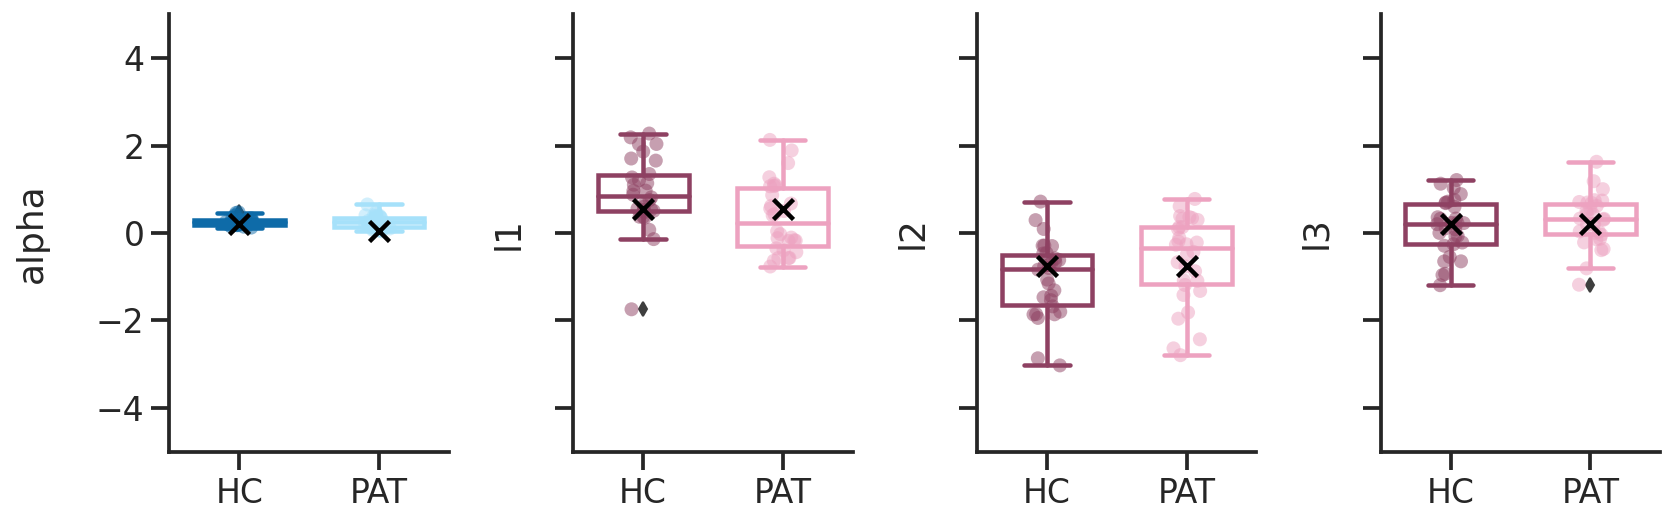

In [18]:
show_recovery(data, 'vary_lr')